# Importing libraries


In [2]:
#import the libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3 as sql

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
nltk.download('vader_lexicon')
nltk.download('punkt')

from nltk.sentiment.vader import SentimentIntensityAnalyzer as vad

from sklearn import feature_extraction
from sklearn.metrics import confusion_matrix
from sklearn import model_selection as ms
from sklearn import naive_bayes
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jrucs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jrucs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jrucs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Preprocessing and Data Cleaning

In [4]:
cities = ['Los Angeles', 'San Francisco', 'Chicago', 'Nashville', 'Boston', 'New Orleans', 'Austin', 'Denver']
state = ['CA', 'CA', 'IL', 'TN', 'MA', 'LA', 'TX', 'CO']
s = 0
df_main = pd.DataFrame()

# iterate and read listings local file directory/keep the required columns for merging

for city in cities:
    print(city)
    listings = pd.read_csv(f'{city}/listings.csv')
    listings = listings.loc[:, ['id',
                         'name',
                         'host_location',
                         'neighbourhood_cleansed',
                         'latitude',
                         'longitude',
                         'price',
                         'review_scores_value']]

    # read reviews local file directory/keep the required columns for merging
    reviews = pd.read_csv(f'{city}/reviews.csv')
    reviews = reviews.loc[:, ['listing_id', 'comments']]

    # merge the listing and reviews datasets and keep only the required columns for our use case
    df = listings.merge(reviews, left_on='id', right_on='listing_id')
    df = df.loc[:, ['id',
                    'name',
                    'host_location',
                    'neighbourhood_cleansed',
                    'latitude',
                    'longitude',
                    'price',
                    'review_scores_value',
                    'comments']]

    # rename columns & from identified list variables, change the value to city, state
    df = df.rename(columns={'host_location':'location', 'review_scores_value':'review_scores'})
    df['location'] = f'{city}, {state[s]}'

    # remove non-ASCII characters
    u = df.select_dtypes(object)
    df[u.columns] = u.apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

    # remove html tags from the comments
    df['comments'] = df['comments'].str.replace(r'<[^<>]*>', '', regex=True)

    # remove punctuation
    df['comments'] = df['comments'].str.replace(r'[^\w\s]+', '', regex=True)

    # remove whitespace
    df['comments'] = df['comments'].str.strip()

    # drop any rows with duplicate comments
    df = df.drop_duplicates(['comments'])

    # drop rows that are missing values
    df = df.dropna()
    
    # query review_scores column for <= 3.0 and > 3.0, then groupby the id column
    # take 10 samples from <= 3.0 and 5 samples from > 3.0
    df_tail = df.query('review_scores <= 3.0').groupby('id').sample(10, replace=True)
    df = df.query('review_scores > 3.0').groupby('id').sample(5, replace=True)
    df = df.append(df_tail)

    # drop any rows with duplicate comments
    df = df.drop_duplicates(['comments'])

    # drop rows that are missing values
    df = df.dropna()

    # convert the comments values to string and lowercase
    df['comments'] = df['comments'].astype(str)
    df['comments'] = df['comments'].str.lower()

    # tokenize words in the comments
    df['comments'] = df['comments'].apply(word_tokenize)

    # remove stop words from the tokens
    df['comments'] = df['comments'].apply(lambda x: ' '.join([item for item in x if item not in stop]))

    # merging files
    df_main = df_main.append(df)

    # increment s to iterate through given city/state lists
    s += 1

Los Angeles
San Francisco
Chicago
Nashville
Boston
New Orleans
Austin
Denver


# Vader Sentiment Analysis

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as vad

# copying the data into a new dataframe called vader
#vader = df_main.copy()
sentiment = vad()

# making additional columns for sentiment score in the vader dataframe
sen = ['Positive', 'Negative', 'Neutral']
sentiments = [sentiment.polarity_scores(i) for i in df_main['comments'].values]
df_main['Vad_Negative_Score'] = [i['neg'] for i in sentiments]
df_main['Vad_Positive_Score'] = [i['pos'] for i in sentiments]
df_main['Vad_Neutral_Score'] = [i['neu'] for i in sentiments]
df_main['Vad_Compound_Score'] = [i['compound'] for i in sentiments]
score = df_main['Vad_Compound_Score'].values
t = []

for i in score:
    if i >= 0.05:
        t.append('Positive')
    elif i <= -0.05:
        t.append('Negative')
    else:
        t.append('Neutral')
        
df_main['Overall_Sentiment'] = t

<AxesSubplot:title={'center':'Over All Sentiment'}, ylabel='Overall_Sentiment'>

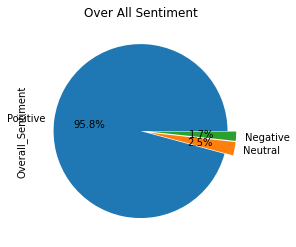

In [6]:
# pie chart
explode = [0, 0.1, 0.1]
df_main["Overall_Sentiment"].value_counts().plot.pie(title="Over All Sentiment",autopct='%1.1f%%',
                        explode = explode
                                 )

# Building Classifiers

In [7]:
# Count Vectorization
counts = feature_extraction.text.CountVectorizer()
X = counts.fit_transform(df_main['review_scores'].astype(str).values)
X.shape

(318140, 89)

In [8]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df_main['Overall_Sentiment']= label_encoder.fit_transform(df_main['Overall_Sentiment'])
df_main['Overall_Sentiment'].unique()
y = df_main['Overall_Sentiment'].values

In [9]:
# Train Test Split
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# print final dataset
df1 = df_main.to_csv('Dataset_Final.csv', sep=',', index=False)

# Multinomial Naive Bayes

In [10]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

m3 = 'MultinomialNB'
rf = MultinomialNB()
classifier = rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)           
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("\n")

score_rf = rf_acc_score*100
print("MultinomialNB:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))

# calculate precision, recall, F-Measure
precision = precision_score(y_test, rf_predicted, labels=[2, 0, 1], average='micro')
print('Precision: %.3f' % precision)
recall = recall_score(y_test, rf_predicted, labels=[2, 0, 1], average='micro')
print('Recall: %.3f' % recall)
score = f1_score(y_test, rf_predicted,  average='micro')
print('F-Measure: %.3f' % score)



MultinomialNB: 95.85874143458855 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1103
           1       0.00      0.00      0.00      1532
           2       0.96      1.00      0.98     60993

    accuracy                           0.96     63628
   macro avg       0.32      0.33      0.33     63628
weighted avg       0.92      0.96      0.94     63628

Precision: 0.959
Recall: 0.959
F-Measure: 0.959


In [11]:
!pip install mlxtend

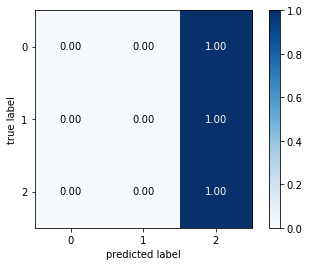

In [12]:
# Imports
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

figure, ax = plot_confusion_matrix(conf_mat = rf_conf_matrix,
                                  #  class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

# Support Vector Machine (SVM)

In [13]:
# SVM
from sklearn import svm

m3 = 'SVM'
rf =  svm.SVC(decision_function_shape='ovo')
classifier = rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)           
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("\n")

score_rf = rf_acc_score*100
print("SVM:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))



SVM: 95.85874143458855 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1103
           1       0.00      0.00      0.00      1532
           2       0.96      1.00      0.98     60993

    accuracy                           0.96     63628
   macro avg       0.32      0.33      0.33     63628
weighted avg       0.92      0.96      0.94     63628



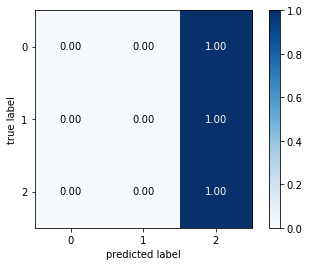

Precision: 0.959
Recall: 0.959
F-Measure: 0.959


In [14]:
# Confusion Matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

figure, ax = plot_confusion_matrix(conf_mat = rf_conf_matrix,
                                  #  class_names = classes,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)

plt.show()

# calculate precision, recall, F-Measure
precision = precision_score(y_test, rf_predicted, labels=[2, 0, 1], average='micro')
print('Precision: %.3f' % precision)
recall = recall_score(y_test, rf_predicted, labels=[2, 0, 1], average='micro')
print('Recall: %.3f' % recall)
score = f1_score(y_test, rf_predicted,  average='micro')
print('F-Measure: %.3f' % score)

# Random Forest Classifier

In [15]:
# Random Forest Classifier
#!pip install scikit-learn
#from sklearn.ensemble import _forest as forest
from sklearn.ensemble import RandomForestClassifier

rf =  RandomForestClassifier(max_depth=3)
classifier = rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)           
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("\n")

score_rf = rf_acc_score*100
print("Random Forest :",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))

# calculate precision, recall, F-Measure
precision = precision_score(y_test, rf_predicted, labels=[2, 0, 1], average='micro')
print('Precision: %.3f' % precision)
recall = recall_score(y_test, rf_predicted, labels=[2, 0, 1], average='micro')
print('Recall: %.3f' % recall)
score = f1_score(y_test, rf_predicted,  average='micro')
print('F-Measure: %.3f' % score)



Random Forest : 95.85874143458855 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1103
           1       0.00      0.00      0.00      1532
           2       0.96      1.00      0.98     60993

    accuracy                           0.96     63628
   macro avg       0.32      0.33      0.33     63628
weighted avg       0.92      0.96      0.94     63628

Precision: 0.959
Recall: 0.959
F-Measure: 0.959


# Build a SQLite for Backend

In [ ]:
import sqlite3 as sql

# create sql database from csv file
dataset = pd.read_csv("Dataset_Final.csv", header=0)
db_conn = sql.connect("airbnb_dataset.db")
dataset.to_sql("airbnb_dataset", db_conn, if_exists='append', index=False)

# test case
#austinlisting = pd.read_sql("SELECT * FROM airbnb_dataset where id = 5456 LIMIT 5", db_conn)
#print(austinlisting)

db_conn.close()

In [ ]:
# create primary key
db_conn = sql.connect("airbnb_dataset.db")
con = db_conn.cursor()

con.execute(
    """CREATE TABLE listing (
        id INTEGER, 
        name TEXT,
        location TEXT,
        neighbourhood TEXT,
        latitude REAL,
        longitude REAL,
        price REAL,
        review_scores REAL,
        comments TEXT,
        PRIMARY KEY(id)
        );"""
)

db_conn.close()